# Network-Based Harmonic Spectral Analysis using Pytorch

> V. Choqueuse

The objective of this notebook is to illustrate the benefit of using a deep learning library for parametric spectral estimation.

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,fftfreq
from scipy.signal import find_peaks
import torch

## Context

Let us assume a signal composed of $L$ (real-valued) cosine components :

$$x[n]=\sum_{n=0}^{L-1}a_n\cos(w_l n+\varphi_n)$$

where the vector containing the $L$ angular frequencies $\mathbf{w} =[w_0,\cdots, w_{L-1}]^T$ can be expressed as

$$\mathbf{w} = \mathbf{F}\boldsymbol  \omega $$


where $\mathbf{w}$ is $K\ll L$ vector of parameters. In this notebook, we consider the harmonic case where

$$\mathbf{F}=\begin{bmatrix}1\\2\\3\\\vdots\\L\end{bmatrix}$$

In parametric analysis, the goal is to estimate the signal parameters, i.e. $\boldsymbol \theta=\{\mathbf{a},\boldsymbol  \omega,\boldsymbol\varphi\}$, from $\mathbf{x}=[x[0],\cdots,x[N-1]]$. A classical technique for parameter estimation is based on the Least-Squares (LS) technique. Using the LS technique, the goal is to minimize the following metric

$$\mathcal{J}(\mathbf{w},\mathbf{c})=\|\mathbf{x}-\mathbf{A}(\boldsymbol  \omega)\mathbf{c}\|^2$$

where $\mathbf{c}$ is a complex vector depending on $\mathbf{a}$ and $\boldsymbol\varphi$.
This optimization problem can be divided into two steps [(more)](https://epubs.siam.org/doi/abs/10.1137/0710036):

* **Step 1**: Estimation of the angular frequencies $\boldsymbol \omega$ using the Variational Projection approach

$$\widehat{\boldsymbol \omega} =\arg \min_{\boldsymbol \omega} \|\mathbf{P}^{\perp}(\boldsymbol \omega)\mathbf{x}\|^2$$

where $\mathbf{P}^{\perp}(\boldsymbol \omega)=\mathbf{I}_N-\mathbf{A}(\boldsymbol \omega)\mathbf{A}^{\dagger}(\boldsymbol \omega)$ is the orthogonal projector into the noise subspace.

* **Step 2**: LS Estimation of the phasor ($\mathbf{a}$, $\boldsymbol\varphi$).

The first step is the most computational demanding task and is usually performed using the Levenberg-Marquardt algorithm. A classical low-complexity approach for spectral estimation is based on the periodogram. Even if this approach has low computational complexity, it usually suffers from a poor spectral resolution. Other approaches include subspace techniques (MUSIC, ESPRIT).


In this notebook, I show how to estimate the signal parameters using a two-step approach:

* Initialization of the parameters $\boldsymbol \theta=\{\mathbf{a},\boldsymbol \omega,\boldsymbol\varphi\}$ using the low-complexity periodogram technique.
* Refined estimation of the parameters using a Pytorch custom network.

In [156]:
def signal_model(a_list,w_list,phi_list,N_vect,sigma2 = 0):
    L = len(a_list)
    x = np.zeros(len(N_vect))
    
    F = np.arange(1,L+1,dtype=np.float64).reshape((-1,1)) # harmonic case
    omega_list = np.matmul(F,[w_list]) # extract harmonic frequencies

    for k in range(L):
        x += a_list[k]*np.cos(omega_list[k]*N_vect+phi_list[k])

    b = np.sqrt(sigma2)*np.random.randn(len(N_vect))
    x += b
    return x

## Signal Generation

Let us consider the following noisy signal composed of $L=5$ harmonic real-valued sine waves.

value of w0=[0.37699111843077515]


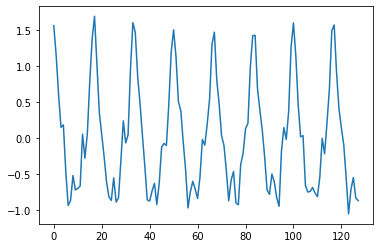

In [157]:
# signal parameter
Fs = 1000
N = 2**7
L = 5
N_vect = np.arange(N,dtype=np.float64)

a_list = [1,0.3,0.11,0.243,0.015]
w_list = [2*np.pi*60.0/Fs]
phi_list = [0,-0.2,0,0.4,-3.14]
sigma2 = 0.01

# generate signal
x = signal_model(a_list,w_list,phi_list,N_vect,sigma2 = sigma2)
plt.plot(x,label="signal");

print("value of w0={}".format(w_list))

## Periodogram based spectral Estimation

To estimate the signal parameter, a simple technique is based on the periodogram. First, the fndamental angular frequency is estimated by locating the highest peak of the periodogram. Then, the amplitude and the phase of the sine wave signals are extracted from these $L$ peaks.

value of w0=0.39269908169872414


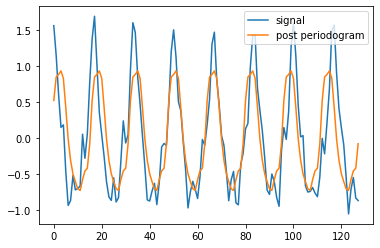

In [158]:
N = len(x)
fft_x = 2*fft(x)/N
freq_list = fftfreq(N)
fft_x_half = fft_x[:int(N/2)]
peaks_locations,_ = find_peaks(np.abs(fft_x_half)**2)

# identification of the first peak (which is assumed to corresponds to the fundamental component)
fft_x_peaks_abs = np.abs(fft_x[peaks_locations])
index_sorted = np.argsort(fft_x_peaks_abs)[::-1]
peaks_locations = peaks_locations[index_sorted[0]] # keep the highest peak

# compute initial parameters
w_init = 2*np.pi*freq_list[peaks_locations]
index = peaks_locations*np.arange(1,6) # get the index for the L harmonics
c = fft_x_half[index]  
a_init = np.abs(c)
phi_init = np.angle(c)

x_est = signal_model(a_init,w_init,phi_init,N_vect)

plt.plot(x,label="signal")
plt.plot(x_est,label="post periodogram")
plt.legend();

print("value of w0={}".format(w_init))

## Refined Estimation using Pytorch


### Network structure 

Let us consider a network with input $\mathbf{N}=[1,2,3,\cdots,N]$. In the following we construct a network composed of 4 layers:

* The first layer performs a multiplication between $\omega_l$ and $\mathbf{N}$ for $l\in \{1,\cdots,L\}$ (input: $N$, output: $L\times N$)
* The second layer add the phase term $\varphi_l$ for $l\in \{1,\cdots,L\}$ (input: $L\times N$, output: $L\times N$)
* The third layer is a non-linear layer that applies the cosine function (input: $L\times N$, output: $L\times N$)
* The fourth layer performs a multiplication between $a_l$ and the output of the previous layer (input: $L\times N$, output: $L\times N$)

The output of the network corresponds to the $L$ harmonic components (size $L\times N$).

In [159]:
class Amp_Net(torch.nn.Module):
    def __init__(self,scale):
        super(Amp_Net, self).__init__()
        self.scale = torch.nn.Parameter(torch.tensor(scale))
        
    def forward(self, x):
        scale = self.scale[:, None] 
        y = scale*x
        return y
    
class Amp2_Net(torch.nn.Module):
    def __init__(self,scale,L):
        super(Amp2_Net, self).__init__()
        F = np.arange(1,L+1,dtype=np.float64).reshape((-1,1))
        self.F = torch.from_numpy(F)
        self.scale = torch.nn.Parameter(torch.tensor(scale))
        
    def forward(self, x):
        scale = torch.matmul(self.F,self.scale)
        scale = scale[:, None] 
        y = scale*x
        return y

class Bias_Net(torch.nn.Module):
    def __init__(self,bias_vect):
        super(Bias_Net, self).__init__()
        self.b = torch.nn.Parameter(torch.Tensor(bias_vect))

    def forward(self, x):
        bias = self.b[:, None] 
        y = x + bias
        return y

class Full_Net(torch.nn.Module):

    def __init__(self,a_init,w_init,phi_init):
        super(Full_Net, self).__init__()
        self.amp1 = Amp2_Net([w_init],len(a_init))
        self.bias1 = Bias_Net(phi_init)
        self.amp2 = Amp_Net(a_init)

    def forward(self, x):
        x2 = self.amp1(x)         # layer 1: w_l*n_vect (*L)
        x3 = self.bias1(x2)       # layer 2: w_l*n_vect + phi_l (*L)
        x4 = torch.cos(x3)        # layer 3: cos(w_l*n_vect + phi_l) (*L)
        x5 = self.amp2(x4)        # layer 4: a_l cos(w_l*n_vect + phi_l) (*L)
        return x5

That's it ! Now, let us improve our periodogram based estimator. 

In [160]:
model = Full_Net(a_init,w_init,phi_init)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_vect_torch = torch.from_numpy(N_vect)
y_torch = torch.from_numpy(x)

for t in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    Y_pred = model(n_vect_torch)
    y_pred = torch.sum(Y_pred,dim=0)  #sum the L components here

    # Compute and print loss
    loss = criterion(y_pred, y_torch)
    if t % 1000 == 0:
        print("it {}: loss={}".format(t, loss.item()/N))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("value of w0 - {}".format(list(model.parameters())[0]))

it 0: loss=0.2109513815299625
it 1000: loss=0.02466624136731279
it 2000: loss=0.00982029050183585
it 3000: loss=0.009586733710333407
it 4000: loss=0.009587157632167255
it 5000: loss=0.009608399624227739
it 6000: loss=0.009586529917474758
it 7000: loss=0.009586529917472579
it 8000: loss=0.00958652991747251
it 9000: loss=0.009586529917472528
value of w0 - Parameter containing:
tensor([0.3771], dtype=torch.float64, requires_grad=True)


## Reconstructed signal

The following code plots the noisy signal, the reconstructed signal based on the periodogram technique and the reconstructed signal after Pytorch refined estimation. We can observe that the proposed network is able to improve the fitting. As compared to other optimization technique, the proposed methodology is much more flexible, there is no need to compute gradient explicitely. Furthermore, the network can be easily extended to deal with more complex signal model by using custom layer.

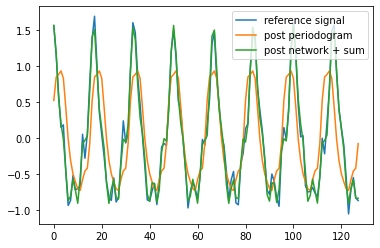

In [161]:
x_est2 = y_pred.detach().numpy()

plt.plot(x,label="reference signal")
plt.plot(x_est,label="post periodogram")
plt.plot(x_est2,label="post network + sum")
plt.legend();

## Demixed Components

The network output is a $L\times N$ tensor where each row corresponds to a single harmonic component. In this configuration, the network is able to separate the harmonic component. The following script plots the $L$ components.

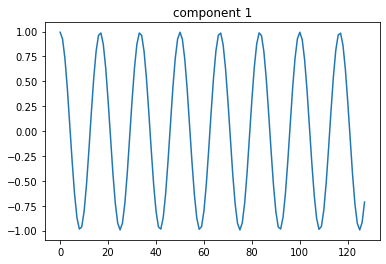

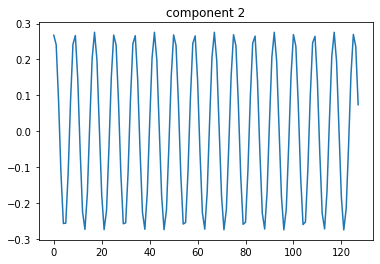

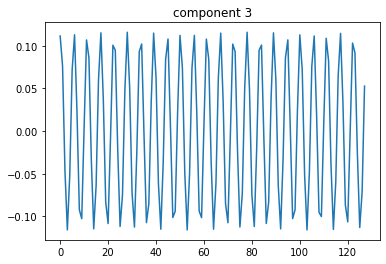

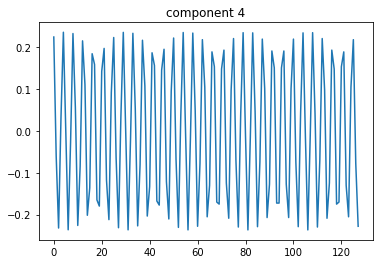

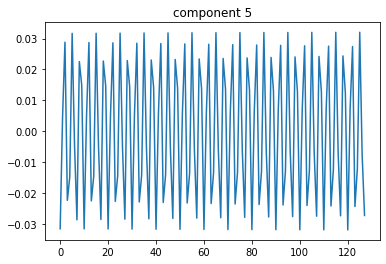

In [162]:
Y_pred2 = Y_pred.detach().numpy()

for k in range(Y_pred2.shape[0]):
    name ="component {}".format(k+1)
    plt.figure()
    plt.title(name)
    plt.plot(Y_pred2[k,:])